<a href="https://colab.research.google.com/github/glazar01/lyric-pulse-sentiment-analysis/blob/main/lyrics_analysis_model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 22 15:29:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install --no-cache-dir transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 153.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 327.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 126.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 157.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 171.0 MB/s eta 0:00:00


In [2]:
!pip3 install torch

In [3]:
# import libraries
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import torch

# Our Data

In [4]:
url = "https://raw.githubusercontent.com/glazar01/lyric-pulse-sentiment-analysis/main/data/SingleLabel.csv"
s_data = pd.read_csv(url)

In [5]:
s_data

,artist,genre,title,album,year,lyrics,label
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness
...,...,...,...,...,...,...,...
1155,The Beatles,Rock,Yesterday,Help!,1965.0,Yesterday\nAll my troubles seemed so far away\...,Sadness
1156,The Sundays,Rock,Love,Blind,1992.0,Picture myself as a thin white child\nBack to ...,Tenderness
1157,The Cure,Rock,Killing an Arab,Boys Don’t Cry,1978.0,Standing on the beach\nWith a gun in my hand\n...,Tension
1158,Garth Brooks,Country,Mom,Man Against Machine,2014.0,"A little baby told God\nHey I'm kinda scared, ...",Tenderness


In [6]:
s_data['label'].unique()

array(['Sadness', 'Tension', 'Tenderness'], dtype=object)

# Model3: emotion-english-distilroberta-base

## link
https://huggingface.co/j-hartmann/emotion-english-distilroberta-base?text=This+movie+always+makes+me+cry..

## description:


## emotion categories
anger 🤬
disgust 🤢
fear 😨
joy 😀
neutral 😐
sadness 😭
surprise 😲


In [7]:
from transformers import pipeline
classifier_3 = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [8]:
prediction_0 = classifier_3(s_data['lyrics'][0])

In [9]:
prediction_0

[[{'label': 'anger', 'score': 0.012856167741119862},
  {'label': 'disgust', 'score': 0.002325346227735281},
  {'label': 'fear', 'score': 0.9192416071891785},
  {'label': 'joy', 'score': 0.012240427546203136},
  {'label': 'neutral', 'score': 0.040510211139917374},
  {'label': 'sadness', 'score': 0.010379848070442677},
  {'label': 'surprise', 'score': 0.0024464528542011976}]]

In [10]:
BATCH_SIZE = 32  # can be adjusted
classifier_3_emotions = ["anger","disgust","fear","joy","neutral","sadness","surprise"]

In [17]:
aggregated_scores = dict.fromkeys(classifier_3_emotions, 0)
aggregated_scores

{'anger': 0,
 'disgust': 0,
 'fear': 0,
 'joy': 0,
 'neutral': 0,
 'sadness': 0,
 'surprise': 0}

In [19]:
lyric = s_data['lyrics'][0]

In [20]:
sentences = [p for p in lyric.split('\n') if p]  # Split by sentences and remove empty ones
sentences

['I will never bother you',
 'I will never promise to',
 'I will never follow you',
 'I will never bother you',
 'Never speak a word again',
 'I will crawl away for good',
 'I will move away from here',
 "You won't be afraid of fear",
 'No thought was put into this',
 'And always knew it would come to this',
 'Things have never been so swell',
 'I have never failed to fail',
 'He-eee-eee-eeey',
 'He-eee-eee-eey',
 'He-eee-eee-ey',
 "You know you're right",
 "You know you're right",
 "You know you're right",
 "I'm so warm and calm inside",
 'I no longer have to hide',
 "Let's talk about someone else",
 'Steaming soup against her mouth',
 'Nothing really bothers her',
 'She just wants to love himself',
 'I will move away from here',
 "You won't be afraid of fear",
 'No thought was put into this',
 "Always knew it'd come to this",
 'Things have never been so swell',
 'I have never failed to fail',
 'He-eee-eee-eey',
 'He-eee-eee-eey',
 'He-eee-eee-eey',
 'He-eee-eee-eey',
 'He-eee-eee-eey

In [21]:
for i in range(0, len(sentences), BATCH_SIZE):
  batch = sentences[i:i+BATCH_SIZE]
  print(batch)

['I will never bother you', 'I will never promise to', 'I will never follow you', 'I will never bother you', 'Never speak a word again', 'I will crawl away for good', 'I will move away from here', "You won't be afraid of fear", 'No thought was put into this', 'And always knew it would come to this', 'Things have never been so swell', 'I have never failed to fail', 'He-eee-eee-eeey', 'He-eee-eee-eey', 'He-eee-eee-ey', "You know you're right", "You know you're right", "You know you're right", "I'm so warm and calm inside", 'I no longer have to hide', "Let's talk about someone else", 'Steaming soup against her mouth', 'Nothing really bothers her', 'She just wants to love himself', 'I will move away from here', "You won't be afraid of fear", 'No thought was put into this', "Always knew it'd come to this", 'Things have never been so swell', 'I have never failed to fail', 'He-eee-eee-eey', 'He-eee-eee-eey']
['He-eee-eee-eey', 'He-eee-eee-eey', 'He-eee-eee-eey', "You know you're right", "You 

In [11]:
# Define a function to get sentiment scores for a lyric split by paragraphs
def get_sentiment_scores_by_sentences(lyric, classifier, classifier_emotions):
    aggregated_scores = dict.fromkeys(classifier_emotions, 0)
    sentences = [p for p in lyric.split('\n') if p]  # Split by sentences and remove empty ones

    # Process sentences in batches
    for i in range(0, len(sentences), BATCH_SIZE):
        batch = sentences[i:i+BATCH_SIZE]
        results_batch = classifier(batch)

        for result in results_batch:
            for res in result:
              label = res['label']
              score = res['score']
              aggregated_scores[label] += score

    # Average the scores
    num_sentences = len(sentences)
    for label in aggregated_scores:
        aggregated_scores[label] /= num_sentences

    return aggregated_scores


In [ ]:
s_data['lyrics'][0]

"I will never bother you\nI will never promise to\nI will never follow you\nI will never bother you\nNever speak a word again\nI will crawl away for good\nI will move away from here\nYou won't be afraid of fear\nNo thought was put into this\nAnd always knew it would come to this\nThings have never been so swell\nI have never failed to fail\n\nHe-eee-eee-eeey\nHe-eee-eee-eey\nHe-eee-eee-ey\nYou know you're right\nYou know you're right\nYou know you're right\n\nI'm so warm and calm inside\nI no longer have to hide\nLet's talk about someone else\nSteaming soup against her mouth\nNothing really bothers her\nShe just wants to love himself\nI will move away from here\nYou won't be afraid of fear\nNo thought was put into this\nAlways knew it'd come to this\nThings have never been so swell\nI have never failed to fail\n\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nYou know you're right\nYou know you're right\nYou know you're right\nYou know you're right\nYou

In [12]:
test_scores = get_sentiment_scores_by_sentences(s_data['lyrics'][0], classifier_3, classifier_3_emotions)
test_scores

{'anger': 0.09795563555754987,
 'disgust': 0.08183298583026044,
 'fear': 0.06483899451476256,
 'joy': 0.13310307843702113,
 'neutral': 0.48436376550567467,
 'sadness': 0.09310112680707659,
 'surprise': 0.04480436745091408}

In [13]:
max(test_scores, key= lambda x: test_scores[x])

'neutral'

In [14]:
# Process the dataset
sentiment_scores = [get_sentiment_scores_by_sentences(lyric, classifier_3, classifier_3_emotions) for lyric in s_data['lyrics']]

In [36]:
def find_max_key(sentiment_scores, ignore_key='neutral'):
    second_max_keys = []
    for lyric_sentiment_scores in sentiment_scores:
        sorted_keys = sorted(lyric_sentiment_scores, key=lambda x: lyric_sentiment_scores[x], reverse=True)
        if sorted_keys[0] == ignore_key:
            # If the first key is 'Ignore,' we consider the second key
            second_max_keys.append(sorted_keys[1])
        else:
            second_max_keys.append(sorted_keys[0])
    return second_max_keys

In [37]:
dominant_sentiments = find_max_key(sentiment_scores, ignore_key='neutral')
dominant_sentiments[0]

'joy'

In [ ]:
dominant_sentiments = [max(lyric_sentiment_scores, key= lambda x: lyric_sentiment_scores[x]) for lyric_sentiment_scores in sentiment_scores]

In [38]:
# Add results to the DataFrame
s_data['sentiment_scores'] = sentiment_scores
s_data['dominant_sentiment'] = dominant_sentiments

In [39]:
s_data

,artist,genre,title,album,year,lyrics,label,sentiment_scores,dominant_sentiment
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness,"{'anger': 0.09795563555754987, 'disgust': 0.08...",joy
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension,"{'anger': 0.08861485862368602, 'disgust': 0.07...",joy
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness,"{'anger': 0.05982099744947033, 'disgust': 0.09...",sadness
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness,"{'anger': 0.0567145453985884, 'disgust': 0.169...",sadness
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness,"{'anger': 0.04347789612384971, 'disgust': 0.12...",surprise
...,...,...,...,...,...,...,...,...,...
1155,The Beatles,Rock,Yesterday,Help!,1965.0,Yesterday\nAll my troubles seemed so far away\...,Sadness,"{'anger': 0.04883131214107076, 'disgust': 0.02...",surprise
1156,The Sundays,Rock,Love,Blind,1992.0,Picture myself as a thin white child\nBack to ...,Tenderness,"{'anger': 0.11378780715293377, 'disgust': 0.05...",joy
1157,The Cure,Rock,Killing an Arab,Boys Don’t Cry,1978.0,Standing on the beach\nWith a gun in my hand\n...,Tension,"{'anger': 0.1241106794747923, 'disgust': 0.167...",fear
1158,Garth Brooks,Country,Mom,Man Against Machine,2014.0,"A little baby told God\nHey I'm kinda scared, ...",Tenderness,"{'anger': 0.0836175062189189, 'disgust': 0.041...",joy


In [40]:
s_data['sentiment_scores'][1159]

{'anger': 0.06023784157481383,
 'disgust': 0.03380432467427895,
 'fear': 0.013110127990578556,
 'joy': 0.14098689586954247,
 'neutral': 0.5901021722309066,
 'sadness': 0.057478963609107515,
 'surprise': 0.10427965723316777}

In [41]:
s_data['label'][1159]

'Sadness'

## Mapping


---


In the original data, we have 3 lables, sadness, tension and tenderness. But in the prediction, there are 6 emotions, sadness, joy, love, anger, fear, surprise respectively. Now we need to map them together.

---
anger 🤬 --> tension <br>
disgust 🤢 --> tension <br>
fear 😨 --> tension <br>
joy 😀 --> tenderness <br>
neutral 😐 --> IGNORE<br>
sadness 😭 --> sadness<br>
surprise 😲 --> tension <br>

---
note: we can also calculte different accuracies if we categorize "surprise" into different categories



In [57]:
emotion_mapping = {
    'anger': 'Tension',
    'disgust': 'Tension',
    'fear': 'Tension',
    'joy': 'Tenderness',
    'anger': 'Tension',
    'sadness': 'Sadness',
    'surprise': 'Tension'
}

In [43]:
mapped_predictions = [emotion_mapping[dominant] for dominant in s_data['dominant_sentiment']]

In [50]:
s_data['mapped_emotion'] = mapped_predictions

In [46]:
original_emotions = s_data['label']
correct_predictions = sum(original == predicted for original, predicted in zip(original_emotions, mapped_predictions))
accuracy_m3 = correct_predictions / len(s_data)


In [47]:
accuracy_m3

0.4396551724137931

# Visualizations

In [48]:
pip install matplotlib seaborn

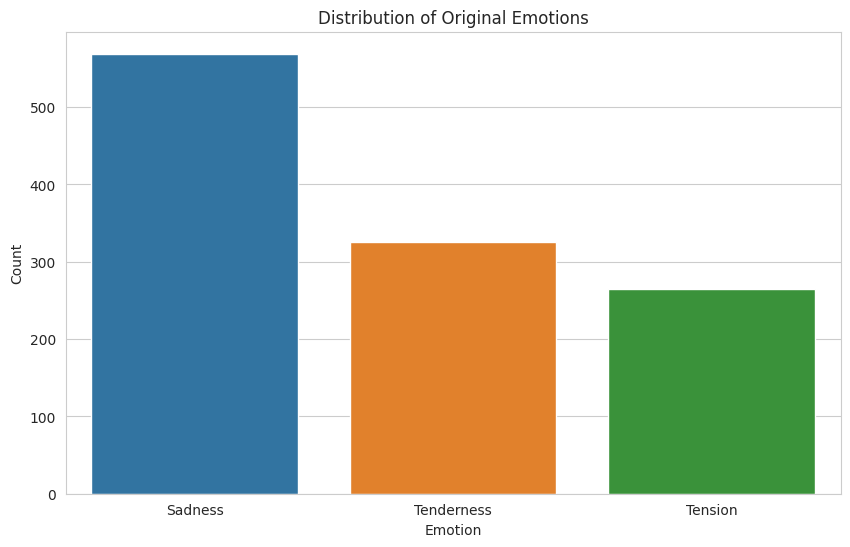

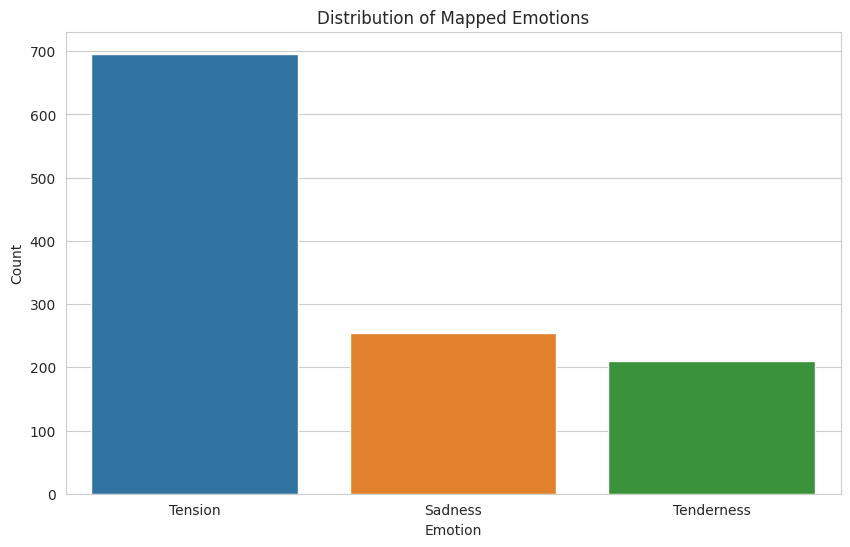

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn
sns.set_style("whitegrid")

# Plot for original_emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=s_data, x='label', order=s_data['label'].value_counts().index)
plt.title('Distribution of Original Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.show()

# Plot for mapped_emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=s_data, x='mapped_emotion', order=s_data['mapped_emotion'].value_counts().index)
plt.title('Distribution of Mapped Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.show()

<ipython-input-58-6bcb3a720b99>:10: RuntimeWarning: invalid value encountered in divide
  accuracies = cm.diagonal() / cm.sum(axis=1)


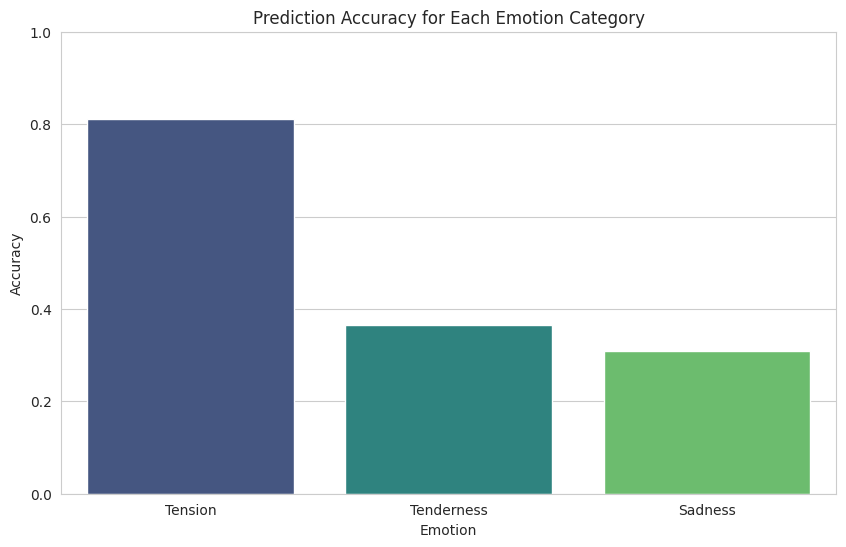

In [58]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(original_emotions, mapped_predictions, labels=list(emotion_mapping.values()))

# Calculate per-category accuracy
accuracies = cm.diagonal() / cm.sum(axis=1)

# Mapping of emotions to their accuracies
emotion_accuracy = dict(zip(list(emotion_mapping.values()), accuracies))

# Visualize the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_accuracy.keys()), y=list(emotion_accuracy.values()), palette="viridis")
plt.title('Prediction Accuracy for Each Emotion Category')
plt.ylabel('Accuracy')
plt.xlabel('Emotion')
plt.ylim(0, 1)  # Setting y-axis limits to be between 0 and 1 for clarity
plt.show()

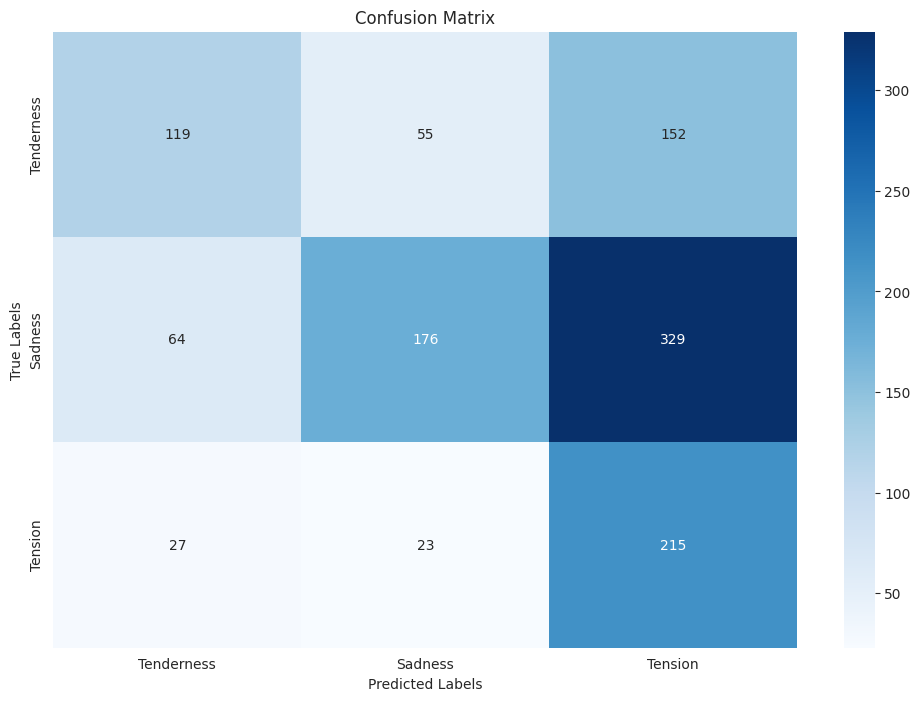

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique labels from both original and mapped emotions
unique_labels = list(set(original_emotions) | set(mapped_predictions))

# Calculate the confusion matrix
cm = confusion_matrix(original_emotions, mapped_predictions, labels=unique_labels)

# Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
